<a href="https://colab.research.google.com/github/JeremyKrick/ComposerNet/blob/jeremy_dev/ComposerNet_jeremy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spectrogram

## Install libraries

In [ ]:
!pip install mido soundfile pretty_midi librosa
#!sudo apt install -y fluidsynth
#!pip install --upgrade pyfluidsynth

## Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from mido import MidiFile
import pretty_midi
import librosa
import librosa.display
import seaborn as sns
import soundfile as sf
import os
import pandas as pd

## Mounting Google Drive to Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load files to dataframe

In [ ]:
def create_dataframe_from_files(root_directory):
    file_data = []

    for root, _, files in os.walk(root_directory):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            subfolder_name = os.path.relpath(root, root_directory)
            file_data.append({
                'File_Path': file_path,
                'Subfolder_Name': subfolder_name,
                'File_Name': file_name
            })

    df = pd.DataFrame(file_data)
    return df

root_directory_path = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/train'
df = create_dataframe_from_files(root_directory_path)

print(df)

                                             File_Path Subfolder_Name  \
0    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
1    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
2    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
3    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
4    /content/drive/MyDrive/AAI 511/Composer_Datase...         mozart   
..                                                 ...            ...   
285  /content/drive/MyDrive/AAI 511/Composer_Datase...         hummel   
286  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   
287  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   
288  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   
289  /content/drive/MyDrive/AAI 511/Composer_Datase...           bach   

         File_Name  
0    mozart002.mid  
1    mozart008.mid  
2    mozart036.mid  
3    mozart042.mid  
4    mozart030.mid

In [ ]:
df

,File_Path,Subfolder_Name,File_Name
0,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart002.mid
1,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart008.mid
2,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart036.mid
3,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart042.mid
4,/content/drive/MyDrive/AAI 511/Composer_Datase...,mozart,mozart030.mid
...,...,...,...
285,/content/drive/MyDrive/AAI 511/Composer_Datase...,hummel,hummel300.mid
286,/content/drive/MyDrive/AAI 511/Composer_Datase...,bach,bach362.mid
287,/content/drive/MyDrive/AAI 511/Composer_Datase...,bach,bach363.mid
288,/content/drive/MyDrive/AAI 511/Composer_Datase...,bach,bach377.mid


## Synthesize MIDI file to np.array

In [ ]:
# Load MIDI file into PrettyMIDI object
midi_data = pretty_midi.PrettyMIDI(df.iloc[0,0])
# Print an empirical estimate of its global tempo
print(midi_data.estimate_tempo())
# Compute the relative amount of each semitone across the entire song,
# a proxy for key
total_velocity = sum(sum(midi_data.get_chroma()))
print([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])
# Shift all notes up by 5 semitones
for instrument in midi_data.instruments:
    # Don't want to shift drum notes
    if not instrument.is_drum:
        for note in instrument.notes:
            note.pitch += 5
# Synthesize the resulting MIDI data using sine waves
audio_data = midi_data.synthesize()

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


234.97935567128462
[0.01140707542123846, 0.07466232665731268, 0.20466635337211955, 0.007106745818508571, 0.1349633131695364, 0.010839810967419877, 0.11396604646581741, 0.08143030781810773, 0.03685961286943024, 0.242262503344323, 0.002356655497109167, 0.07947924859907689]


## Convert MIDI data to waveform

In [ ]:
# Write audio data to .wav format
sf.write('/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/stereo_file1.wav', audio_data, 48000, 'PCM_24')

In [ ]:
# https://www.kaggle.com/code/msripooja/steps-to-convert-audio-clip-to-spectrogram
# Load .wav file
y, sr = librosa.load('/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/stereo_file1.wav')

In [ ]:
print(type(y), type(sr))
print(y.shape, sr)

<class 'numpy.ndarray'> <class 'int'>
(10897865,) 22050


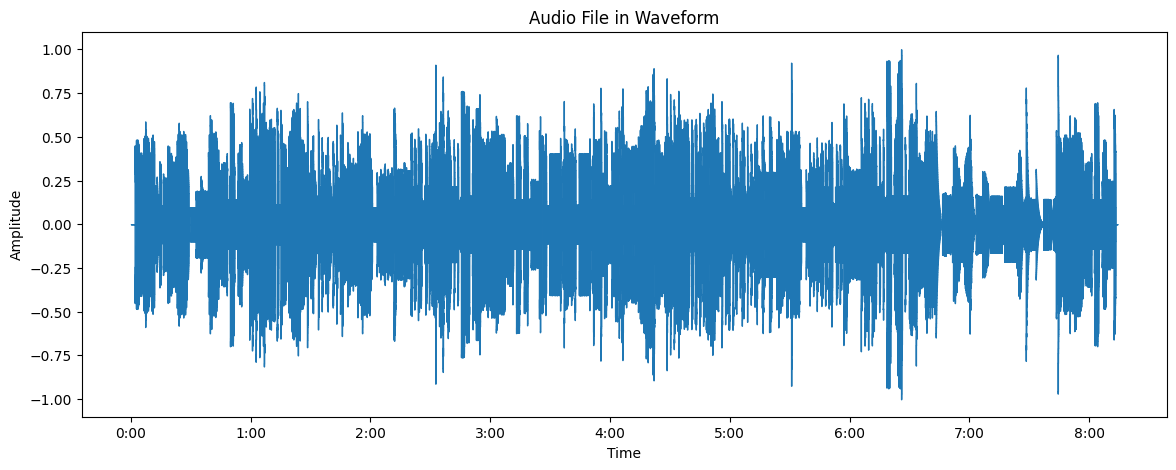

In [ ]:
# Display waveform
plt.figure(figsize=(14, 5))
plt.title('Audio File in Waveform')
plt.ylabel('Amplitude')
librosa.display.waveshow(y, sr=sr)

## Convert MIDI data to spectrogram

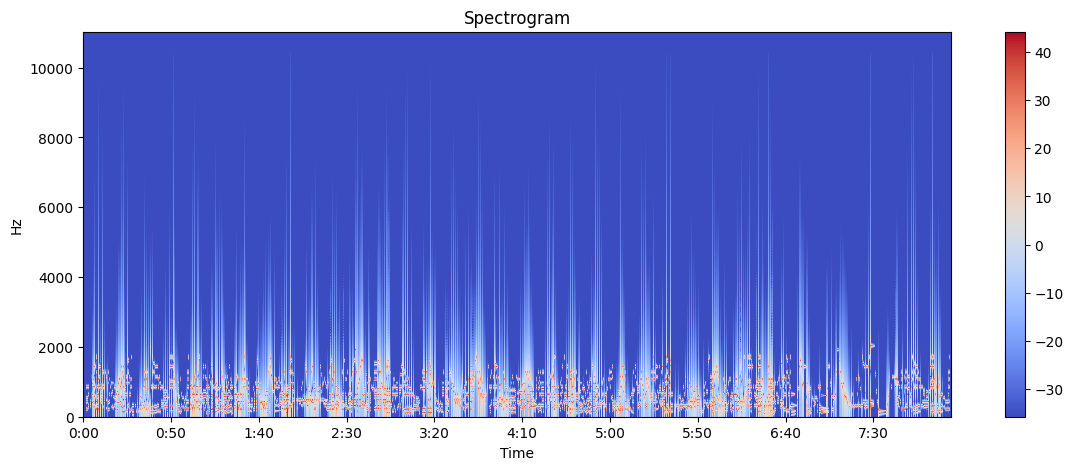

In [ ]:
# Display spectrogram
X = librosa.stft(y)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
plt.title('Spectrogram')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

## Convert MIDI data to logarithmic spectrogram

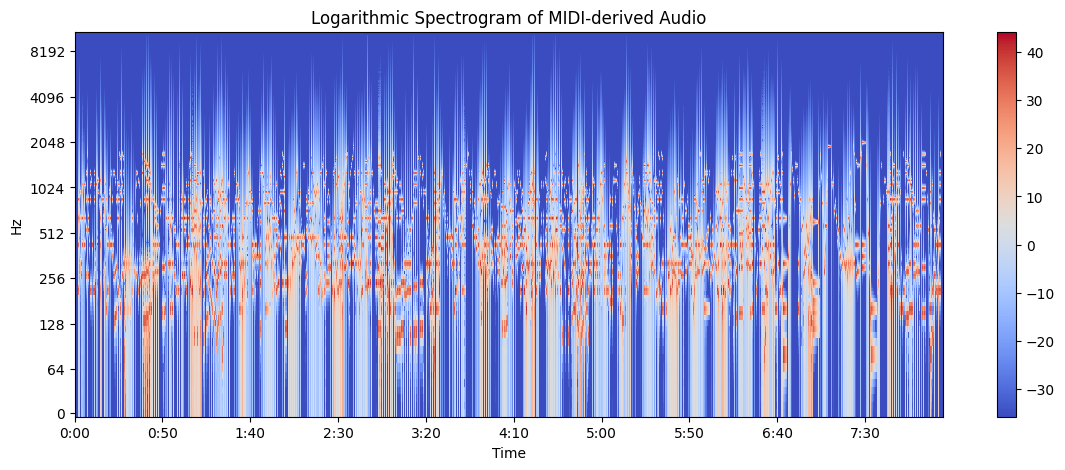

In [ ]:
# Change y-axis to logarithmic form for better visualization
plt.figure(figsize=(14, 5))
plt.title('Logarithmic Spectrogram of MIDI-derived Audio')
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()

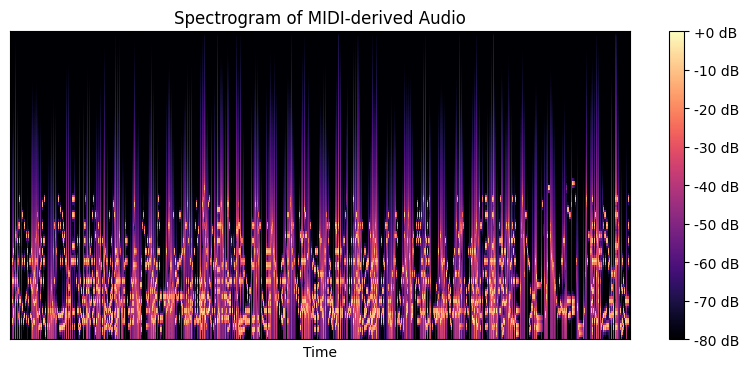

In [ ]:
# Another Spectrogram of MIDI-derived audio
audio_file_path = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/stereo_file1.wav'

def create_spectrogram(audio_file_path):
    y, sr = librosa.load(audio_file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    return spectrogram

# Create a spectrogram
spectrogram = create_spectrogram(audio_file_path)

# Display the spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max))
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of MIDI-derived Audio')
plt.xlabel('Time')
plt.savefig('/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/test.png', bbox_inches='tight', pad_inches=0.0)
plt.show()

## Convert all MIDI to .wav file and logarithmic spectrogram

In [ ]:
def midi_to_audio(midi_file_path, output_audio_path, sr=44100):
    midi_data = pretty_midi.PrettyMIDI(midi_file_path)
    # Print an empirical estimate of its global tempo
    print(midi_data.estimate_tempo())
    # Compute the relative amount of each semitone across the entire song,
    # a proxy for key
    total_velocity = sum(sum(midi_data.get_chroma()))
    print([sum(semitone)/total_velocity for semitone in midi_data.get_chroma()])

    # Shift all notes up by 5 semitones
    for instrument in midi_data.instruments:
      # Don't want to shift drum notes
      if not instrument.is_drum:
        for note in instrument.notes:
          note.pitch += 5

    # Synthesize the resulting MIDI data using sine waves
    audio_data = midi_data.synthesize()
    # Write audio data to .wav format
    sf.write(output_audio_path, audio_data, 48000, 'PCM_24')

def create_spectrogram(audio_file_path):
    y, sr = librosa.load(audio_file_path)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    return spectrogram

def process_midi_files_and_create_spectrograms(df):
    for index, row in df.iterrows():
        midi_file_path = row['File_Path']
        subfolder_name = row['Subfolder_Name']
        file_name = row['File_Name']

        # Convert MIDI to audio
        audio_file_path = f'/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/audio/{subfolder_name}_{file_name[:-4]}.wav'
        midi_to_audio(midi_file_path, audio_file_path)

        # create a spectrogram
        spectrogram = create_spectrogram(audio_file_path)

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max))
        plt.savefig(f'/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/spectrograms/{subfolder_name}_{file_name[:-4]}.png',
                    bbox_inches='tight', pad_inches=0.0)
        plt.close()

# Create directories to save audio and spectrograms
audio_directory = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/audio'
spectrogram_directory = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/spectrograms'
os.makedirs(audio_directory, exist_ok=True)
os.makedirs(spectrogram_directory, exist_ok=True)

# Process MIDI files and create spectrograms
process_midi_files_and_create_spectrograms(df)

## Pre-processing

In [ ]:
from PIL import Image
from sklearn.model_selection import train_test_split

# Load and preprocess spectrogram images
image_directory = '/content/drive/MyDrive/AAI 511/Composer_Dataset/NN_midi_files_extended/spectrograms'
image_size = (775, 308)  # Resize images to this size

images = []
labels = []

for filename in os.listdir(image_directory):
    if filename.endswith('.png'):
        image_path = os.path.join(image_directory, filename)
        label = filename.split('_')[0]  # Extract label from filename
        labels.append(label)

        image = Image.open(image_path)
        #image = image.resize(image_size)
        image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        images.append(image)

# Convert labels to one-hot encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(labels)
onehot_encoder = OneHotEncoder(sparse=False)
labels_encoded = onehot_encoder.fit_transform(integer_encoded.reshape(-1, 1))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Convert data to NumPy arrays
X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_val shape: {}'.format(X_val.shape))
print('y_val shape: {}'.format(y_val.shape))

X_train shape: (232, 308, 775, 4)
y_train shape: (232, 8)
X_val shape: (58, 308, 775, 4)
y_val shape: (58, 8)


## Create and train the CNN model

In [ ]:
model = tf.keras.Sequential([
    # Convolutional first layer
    tf.keras.layers.Conv2D(10, (3, 3), activation='relu', input_shape=(308, 775, 4)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # tf.keras.layers.Conv2D(100, (3, 3), activation='relu'),
    # tf.keras.layers.MaxPooling2D((2, 2)),
    # Make 1-D vector
    tf.keras.layers.Flatten(),
    #tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    # Output layer
    tf.keras.layers.Dense(8, activation='softmax'),
])

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 306, 773, 10)      370       
                                                                 
 dropout_13 (Dropout)        (None, 306, 773, 10)      0         
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 153, 386, 10)     0         
 g2D)                                                            
                                                                 
 conv2d_36 (Conv2D)          (None, 151, 384, 32)      2912      
                                                                 
 dropout_14 (Dropout)        (None, 151, 384, 32)      0         
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 75, 192, 32)      0         
 g2D)                                                

## Compile and train the model

In [ ]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, batch_size=64, validation_data=(X_val, y_val))

Epoch 1/15
4/4 [==============================] - 3s 595ms/step - loss: 57.0031 - accuracy: 0.1552 - val_loss: 34.3879 - val_accuracy: 0.1207
Epoch 2/15
4/4 [==============================] - 2s 400ms/step - loss: 114.2930 - accuracy: 0.1250 - val_loss: 19.1386 - val_accuracy: 0.1207
Epoch 3/15
4/4 [==============================] - 2s 390ms/step - loss: 57.1871 - accuracy: 0.1121 - val_loss: 3.3215 - val_accuracy: 0.1207
Epoch 4/15
4/4 [==============================] - 1s 381ms/step - loss: 11.1597 - accuracy: 0.1509 - val_loss: 2.0491 - val_accuracy: 0.1897
Epoch 5/15
4/4 [==============================] - 1s 379ms/step - loss: 3.0703 - accuracy: 0.2026 - val_loss: 2.0777 - val_accuracy: 0.1724
Epoch 6/15
4/4 [==============================] - 1s 376ms/step - loss: 2.0403 - accuracy: 0.1853 - val_loss: 2.0779 - val_accuracy: 0.1552
Epoch 7/15
4/4 [==============================] - 1s 380ms/step - loss: 2.0057 - accuracy: 0.1724 - val_loss: 2.0652 - val_accuracy: 0.1207
Epoch 8/15
4/

## Evaluate the model

2/2 [==============================] - 0s 44ms/step - loss: 1.6185 - accuracy: 0.4655
Test accuracy: 0.4655172526836395


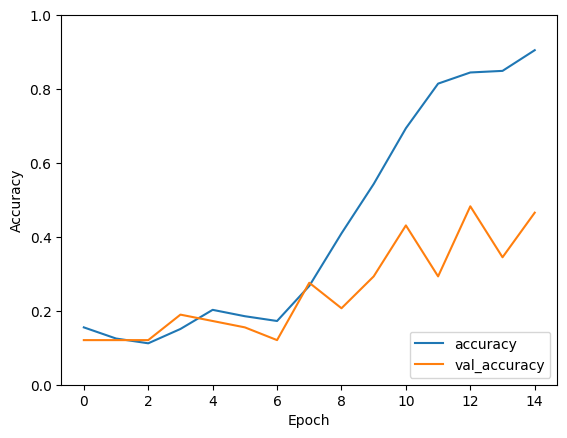

In [ ]:
# Plot model accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_val, y_val)
print('Test accuracy:', test_acc)

## Model metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

y_pred = model.predict(X_val)
y_pred = np.argmax(y_pred, axis=1)
y_val = np.argmax(y_val, axis=1) # convert y_val to single-digit, not one-hot-encoded

# Method to easily print required metrics
def print_metrics(y_val, y_pred):
  print("Accuracy: {}".format(accuracy_score(y_val, y_pred)))
  print("Precision: {}".format(precision_score(y_val, y_pred, average='weighted')))
  print("Recall: {}".format(recall_score(y_val, y_pred, average='weighted')))
  print("F1 Score: {}".format(f1_score(y_val, y_pred, average='weighted')))

print_metrics(y_val, y_pred)

2/2 [==============================] - 0s 46ms/step
Accuracy: 0.46551724137931033
Precision: 0.3826948490995144
Recall: 0.46551724137931033
F1 Score: 0.3848517846339988


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MLP

In [1]:
!pip install mido seaborn pretty_midi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.3/50.3 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 67.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pretty_midi: filename=pretty_midi-0.2.10-py3-none-any.whl size=5592285 sha256=b833e153b253de4794d058d8b8c3f5f82fea377ab1d9160de5cf6c401e7473d6
  Stored in directory: /root/.cache/pip/wheels/cd/a5/30/7b8b7f58709f5150f67f98fde4b891ebf0be9ef07a8af49f25
Successfully built pretty_midi


In [2]:
!sudo apt install -y fluidsynth

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fluid-soundfont-gm libevdev2 libfluidsynth3 libgudev-1.0-0 libinput-bin
  libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a libqt5dbus5
  libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libxcb-icccm4 libxcb-image0 libxcb-keysyms1
  libxcb-render-util0 libxcb-util1 libxcb-xinerama0 libxcb-xinput0 libxcb-xkb1
  libxkbcommon-x11-0 qsynth qt5-gtk-platformtheme qttranslations5-l10n
  timgm6mb-soundfont
Suggested packages:
  fluid-soundfont-gs qt5-image-formats-plugins qtwayland5 jackd
The following NEW packages will be installed:
  fluid-soundfont-gm fluidsynth libevdev2 libfluidsynth3 libgudev-1.0-0
  libinput-bin libinput10 libinstpatch-1.0-2 libmd4c0 libmtdev1 libqt5core5a
  libqt5dbus5 libqt5gui5 libqt5network5 libqt5svg5 libqt5widgets5 libwacom-bin
  libwacom-common libwacom9 libx

In [3]:
#@title Load Libraries
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os
import mido
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from IPython.display import display, Audio
import pretty_midi
import collections
from typing import Optional
from matplotlib import pyplot as plt
import warnings
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import log_loss


In [4]:
#@title Midi Directory

midi_directory = '/classical-music-midi/Composer_Dataset/NN_midi_files_extended/train'

In [5]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [6]:
#@title Unzip files

! unzip /content/drive/MyDrive/Composer_Dataset.zip  -d "/classical-music-midi"

Archive:  /content/drive/MyDrive/Composer_Dataset.zip
   creating: /classical-music-midi/Composer_Dataset/
  inflating: /classical-music-midi/__MACOSX/._Composer_Dataset  
  inflating: /classical-music-midi/Composer_Dataset/.DS_Store  
  inflating: /classical-music-midi/__MACOSX/Composer_Dataset/._.DS_Store  
   creating: /classical-music-midi/Composer_Dataset/NN_midi_files_extended/
  inflating: /classical-music-midi/__MACOSX/Composer_Dataset/._NN_midi_files_extended  
  inflating: /classical-music-midi/Composer_Dataset/NN_midi_files_extended/.DS_Store  
  inflating: /classical-music-midi/__MACOSX/Composer_Dataset/NN_midi_files_extended/._.DS_Store  
   creating: /classical-music-midi/Composer_Dataset/NN_midi_files_extended/test/
  inflating: /classical-music-midi/__MACOSX/Composer_Dataset/NN_midi_files_extended/._test  
   creating: /classical-music-midi/Composer_Dataset/NN_midi_files_extended/train/
  inflating: /classical-music-midi/__MACOSX/Composer_Dataset/NN_midi_files_extended/

In [7]:
#@title Midi to Notes

import mido
from mido import MidiFile
# mid
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    mid = MidiFile(midi_file)
    notes = {
        'pitch': [],
        'start': [],
        'end': [],
        'step': [],
        'duration': []
    }

    prev_start = 0

    for msg in mid:
        if msg.type == 'note_on':
            start = msg.time + prev_start
            end = start + msg.velocity / 127.0  # Calculate end time based on velocity

            notes['pitch'].append(msg.note)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)

            prev_start = start

    return pd.DataFrame(notes)


In [8]:
#@title Review Dataset
def normalize_features(features):
    tempo = (features[0] - 150) / 300
    num_sig_changes = (features[1] - 2) / 10
    resolution = (features[2] - 260) / 400
    time_sig_1 = (features[3] - 3) / 8
    time_sig_2 = (features[4] - 3) / 8
    return [tempo, resolution, time_sig_1, time_sig_2]

def get_features(path):
    try:
        # Test for Corrupted Midi Files
        with warnings.catch_warnings():
            warnings.simplefilter("error")
            mid = MidiFile(path)

            tempo = None
            for msg in mid:
                if msg.type == 'set_tempo':
                    tempo = mido.tempo2bpm(msg.tempo)
                    break

            num_sig_changes = len([msg for msg in mid if msg.type == 'time_signature'])
            resolution = mid.ticks_per_beat
            ts_changes = [msg for msg in mid if msg.type == 'time_signature']
            ts_1 = 4
            ts_2 = 4
            if ts_changes:
                ts_1 = ts_changes[0].numerator
                ts_2 = ts_changes[0].denominator
            return normalize_features([tempo, num_sig_changes, resolution, ts_1, ts_2])
    except:
        return None

In [9]:
count = 0
get_note_names = np.vectorize(pretty_midi.note_number_to_name)

all_features = []
for root, _, files in os.walk(midi_directory):
    for file in files:
        if file.endswith(".mid"):
          #if count >= 20:
          #  break

          midi_file_path = os.path.join(root, file)
          composer = os.path.basename(root)
          features = get_features(midi_file_path)
          #print(file,composer,features)
          if features is not None:
            features.append(composer)
            all_features.append(features)
          count += 1

labeled_features = np.array(all_features)
#labeled_features = np.random.permutation(labeled_features)
np.random.shuffle(labeled_features)

In [11]:
columns = ['Tempo', 'Resolution', 'TS1', 'TS2', 'Composer']
df = pd.DataFrame(labeled_features, columns=columns)

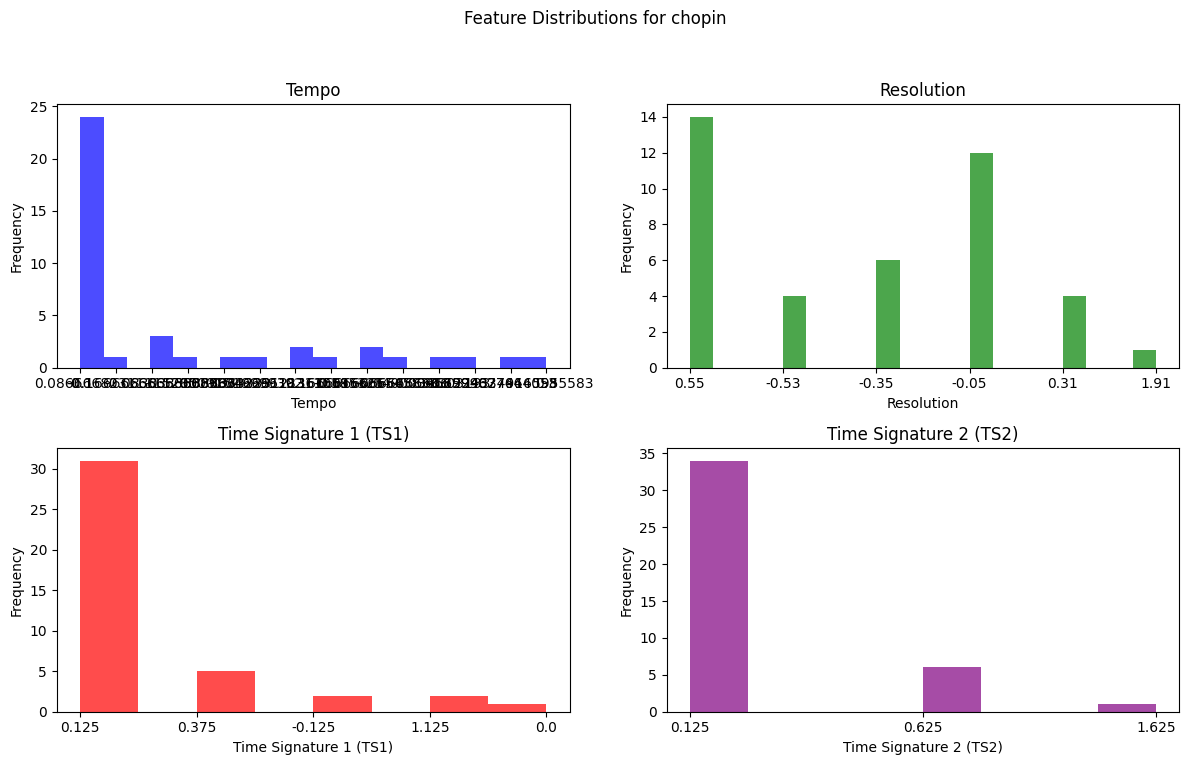

In [12]:
target_composer = 'chopin'

# Filter the DataFrame to include only data for the target composer
filtered_df = df[df['Composer'] == target_composer]

# Create subplots for multiple charts
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle(f'Feature Distributions for {target_composer}')

# Chart 1: Tempo
axs[0, 0].hist(filtered_df['Tempo'], bins=20, color='blue', alpha=0.7)
axs[0, 0].set_title('Tempo')
axs[0, 0].set_xlabel('Tempo')
axs[0, 0].set_ylabel('Frequency')

# Chart 2: Resolution
axs[0, 1].hist(filtered_df['Resolution'], bins=20, color='green', alpha=0.7)
axs[0, 1].set_title('Resolution')
axs[0, 1].set_xlabel('Resolution')
axs[0, 1].set_ylabel('Frequency')

# Chart 3: Time Signature 1 (TS1)
axs[1, 0].hist(filtered_df['TS1'], bins=8, color='red', alpha=0.7)
axs[1, 0].set_title('Time Signature 1 (TS1)')
axs[1, 0].set_xlabel('Time Signature 1 (TS1)')
axs[1, 0].set_ylabel('Frequency')

# Chart 4: Time Signature 2 (TS2)
axs[1, 1].hist(filtered_df['TS2'], bins=8, color='purple', alpha=0.7)
axs[1, 1].set_title('Time Signature 2 (TS2)')
axs[1, 1].set_xlabel('Time Signature 2 (TS2)')
axs[1, 1].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the charts
plt.show()

In [14]:
#@title Identify target variable
X = df.drop('Composer', axis=1)
y = df['Composer']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

In [15]:
#@title Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [26]:
#@title Build Model
from sklearn.neural_network import MLPClassifier

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Reshape the piano roll images to flat vectors
X_train_flattened = X_train.values.reshape(X_train.shape[0], -1)
X_test_flattened = X_test.values.reshape(X_test.shape[0], -1)

# Initialize the MLPClassifier
learning_rate = 0.001  # Change this to your desired learning rate
mlp_model = MLPClassifier(hidden_layer_sizes=(150, 150), solver='adam', activation='relu',
                          learning_rate_init=learning_rate, max_iter=2000, alpha=1e-4, tol=1e-4, random_state=1)

# Train the model
mlp_model.fit(X_train_flattened, y_train)

MLPClassifier(hidden_layer_sizes=(150, 150), max_iter=2000, random_state=1)

In [27]:
#@title Evaluate the Model
# Make predictions on the test set
y_pred = mlp_model.predict(X_test_flattened)

# Convert class labels back to original composer names using the label encoder
predicted_composers = label_encoder.inverse_transform(y_pred)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
#loss = log_loss(y_test, y_pred)

# Display precision, recall, and F1-score
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1))

Accuracy: 40.54%
Precision: 0.57
Recall: 0.41
F1-score: 0.35


# Piano Roll

In [37]:
#@title Preprocess for data visualization

import mido
from mido import MidiFile
# mid
def midi_to_notes(midi_file: str) -> pd.DataFrame:
    mid = MidiFile(midi_file)
    notes = {
        'pitch': [],
        'start': [],
        'end': [],
        'step': [],
        'duration': []
    }

    prev_start = 0

    for msg in mid:
        if msg.type == 'note_on':
            start = msg.time + prev_start
            end = start + msg.velocity / 127.0  # Calculate end time based on velocity

            notes['pitch'].append(msg.note)
            notes['start'].append(start)
            notes['end'].append(end)
            notes['step'].append(start - prev_start)
            notes['duration'].append(end - start)

            prev_start = start

    return pd.DataFrame(notes)


In [44]:
#@title Display Piano Roll (Sample Set)
def plot_piano_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

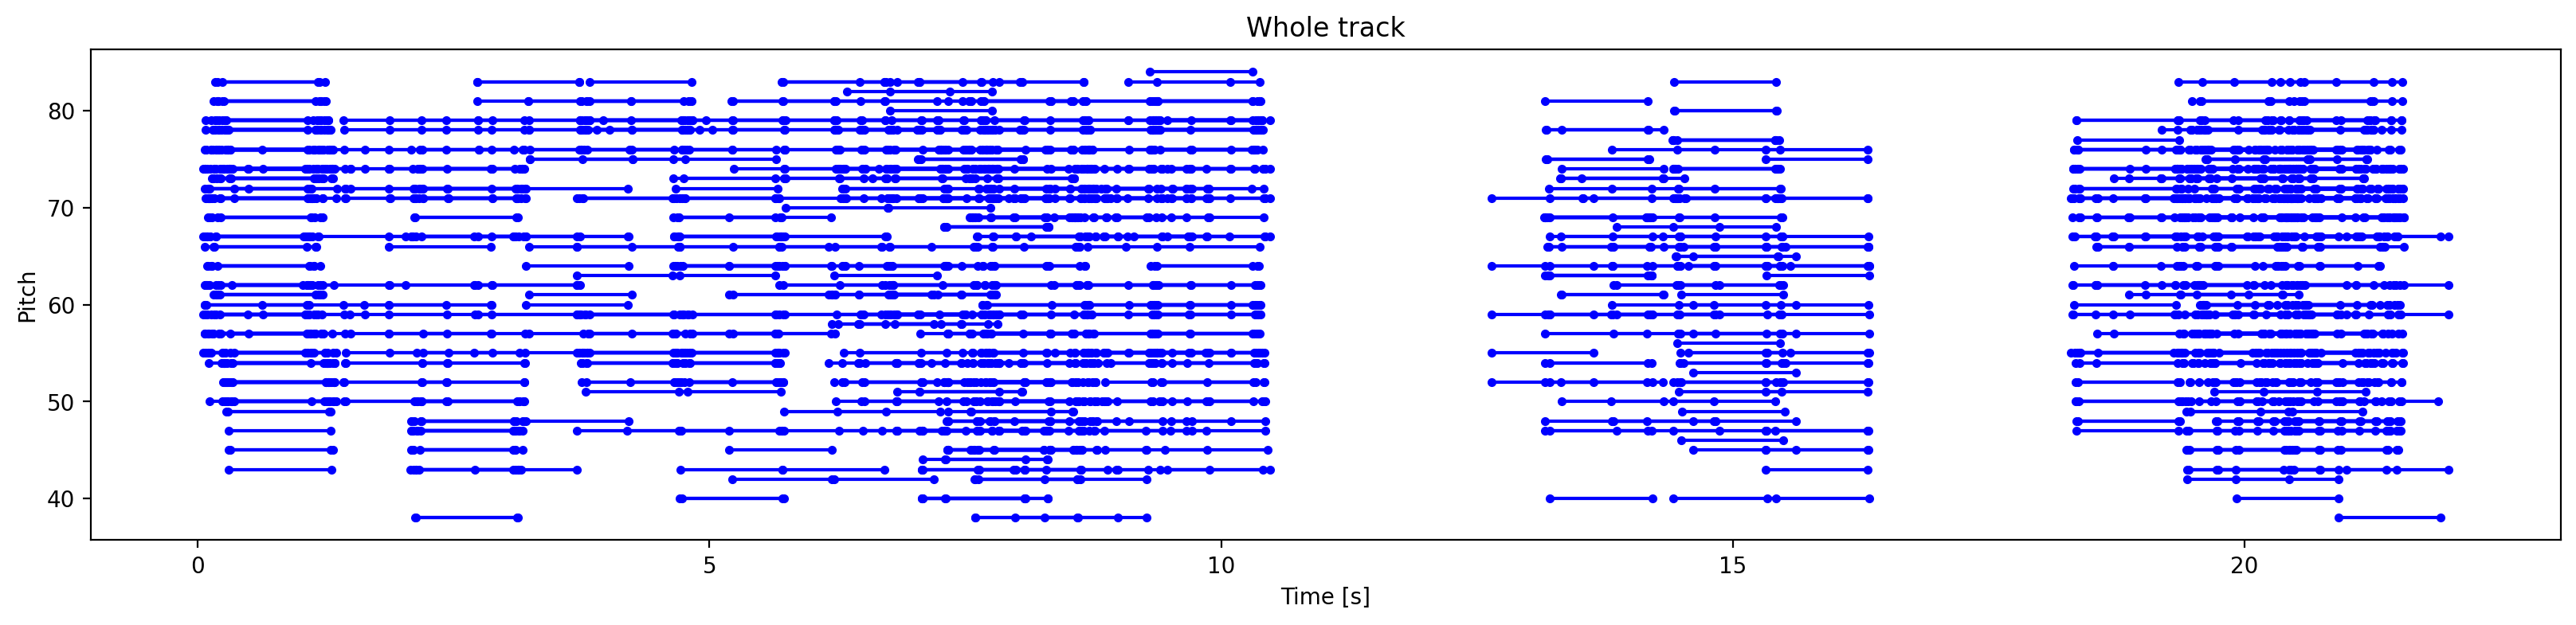

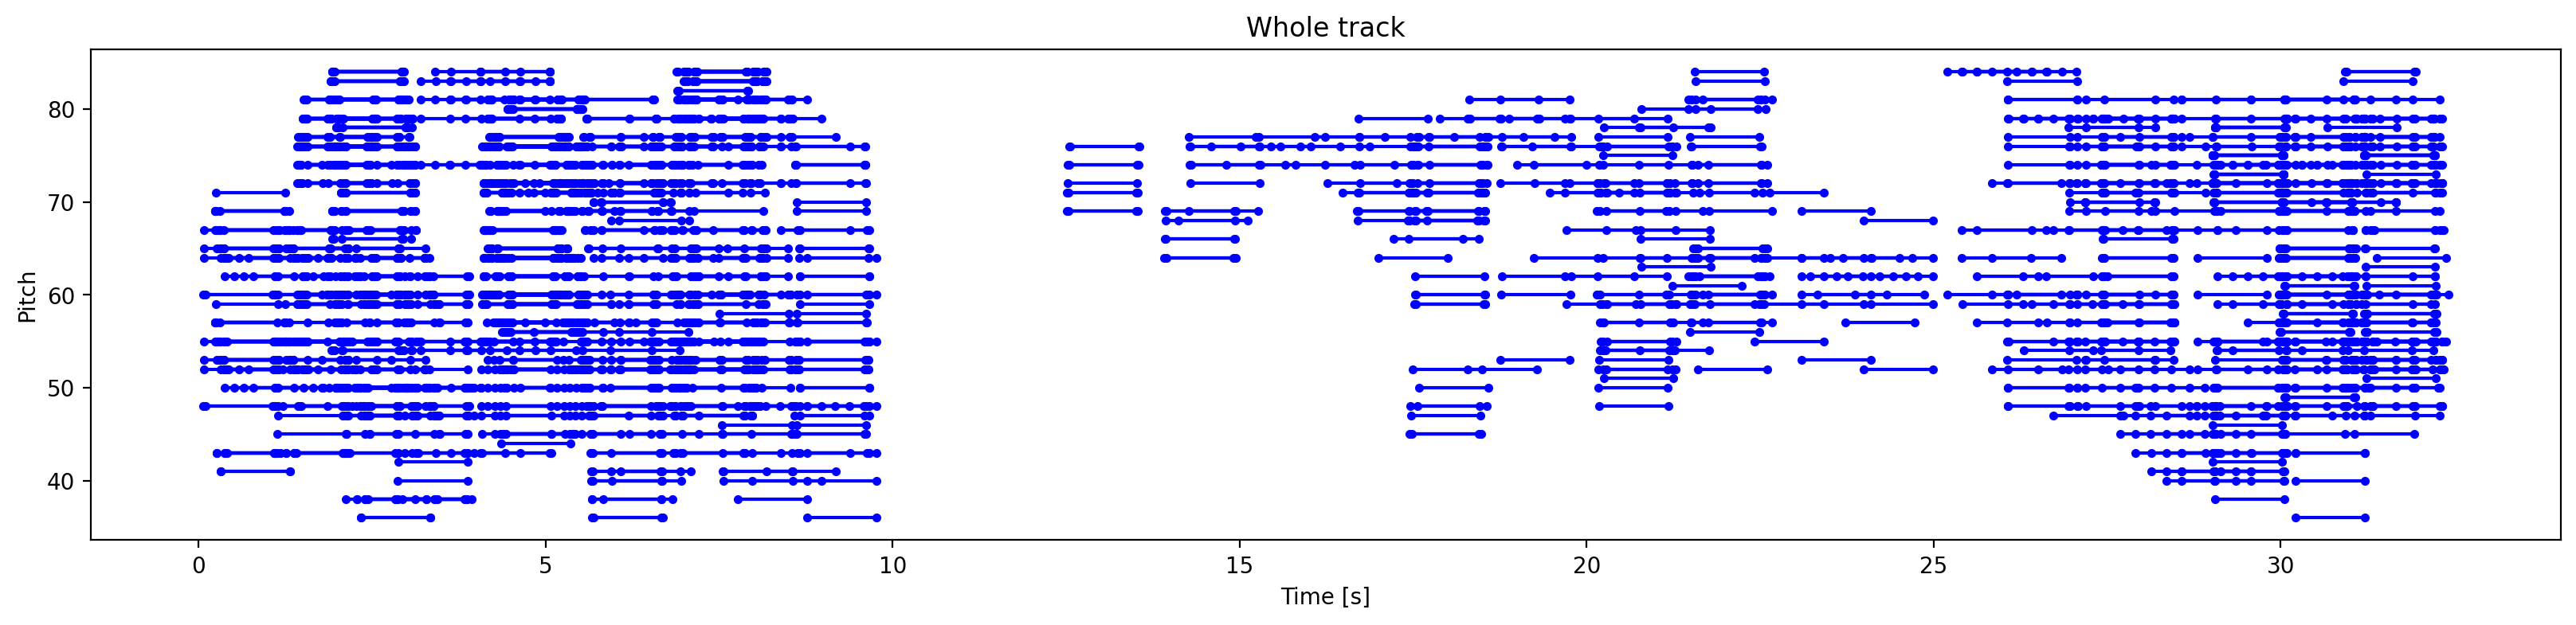

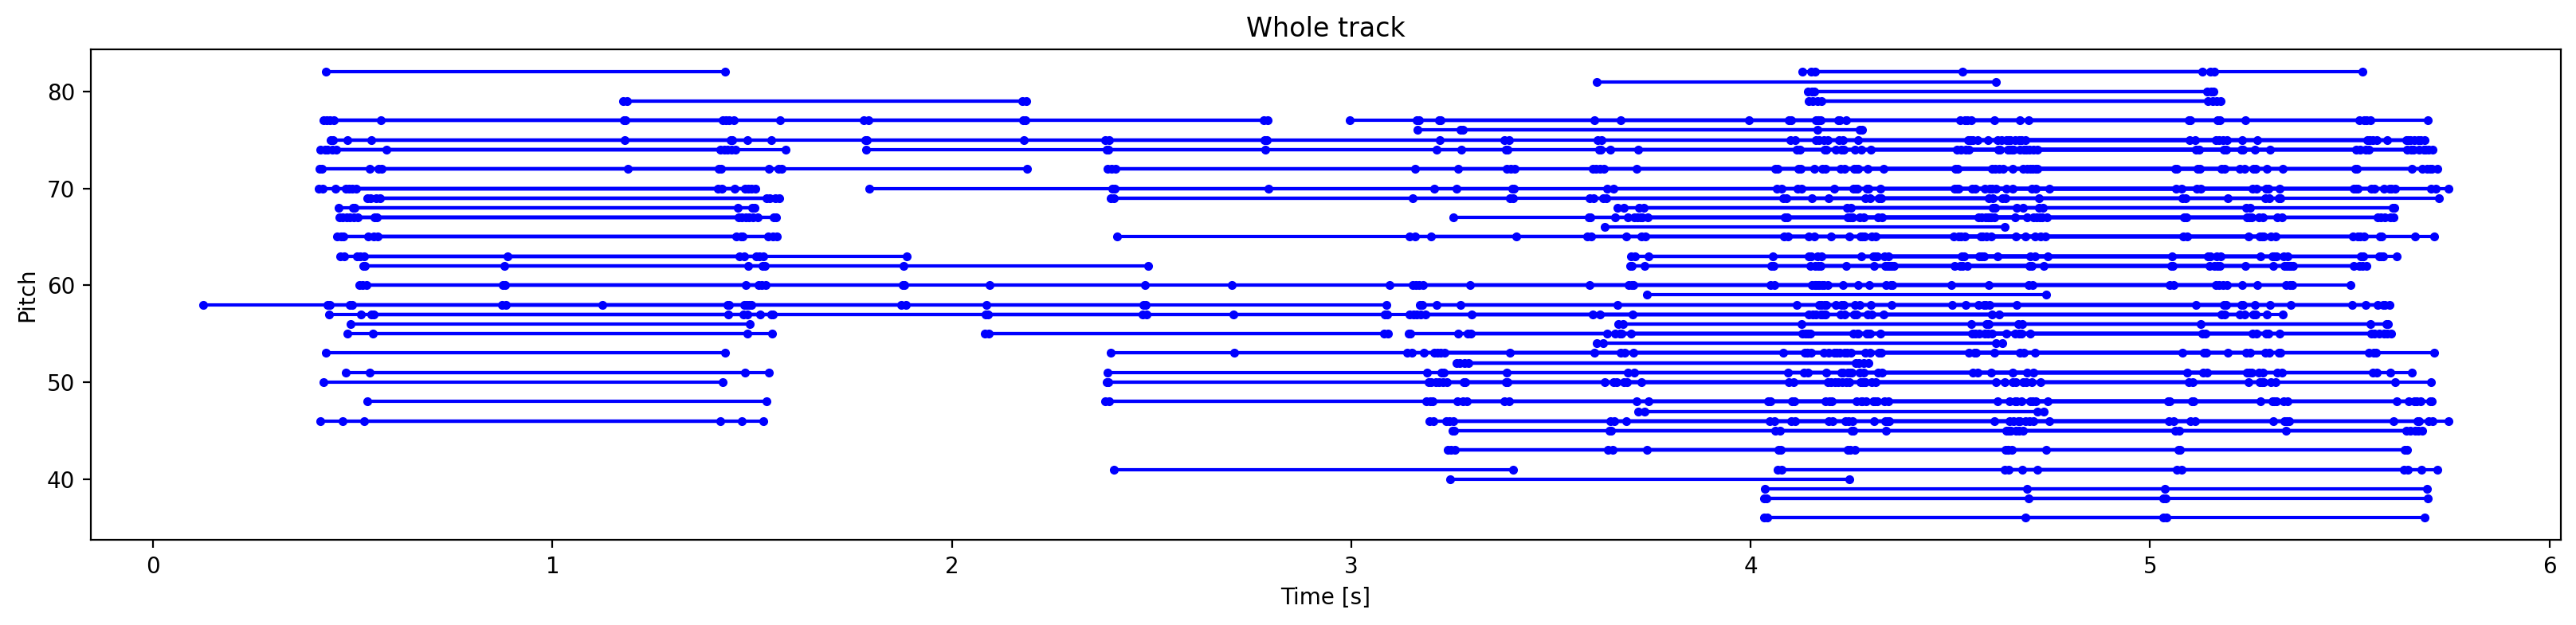

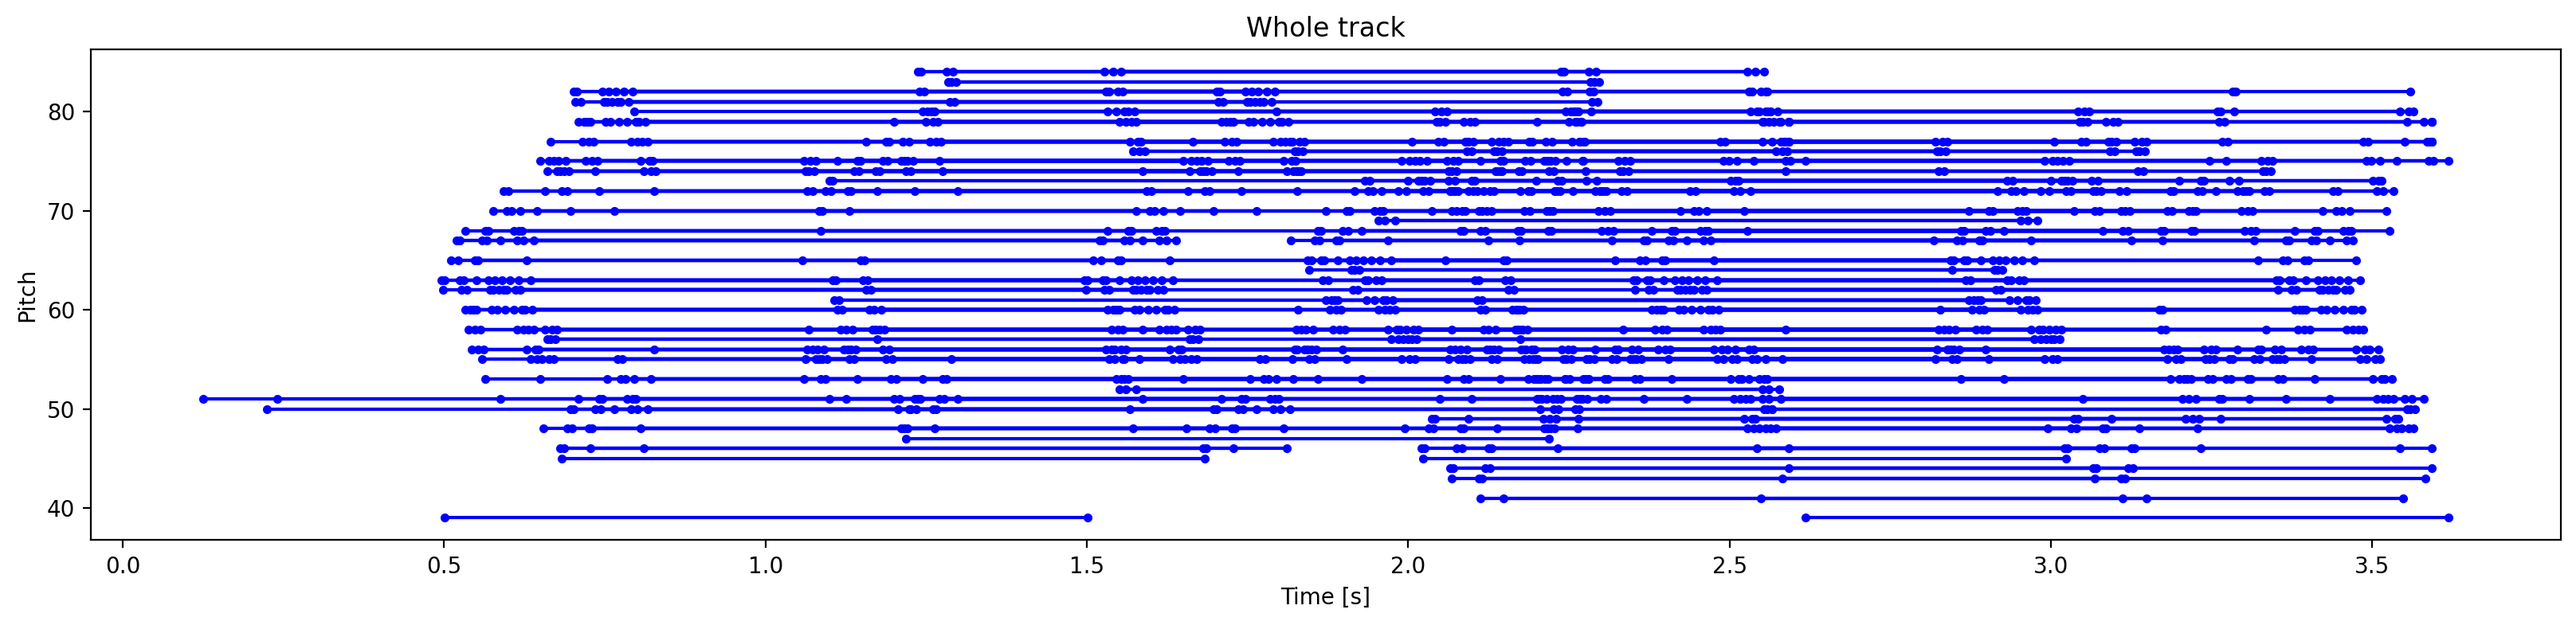

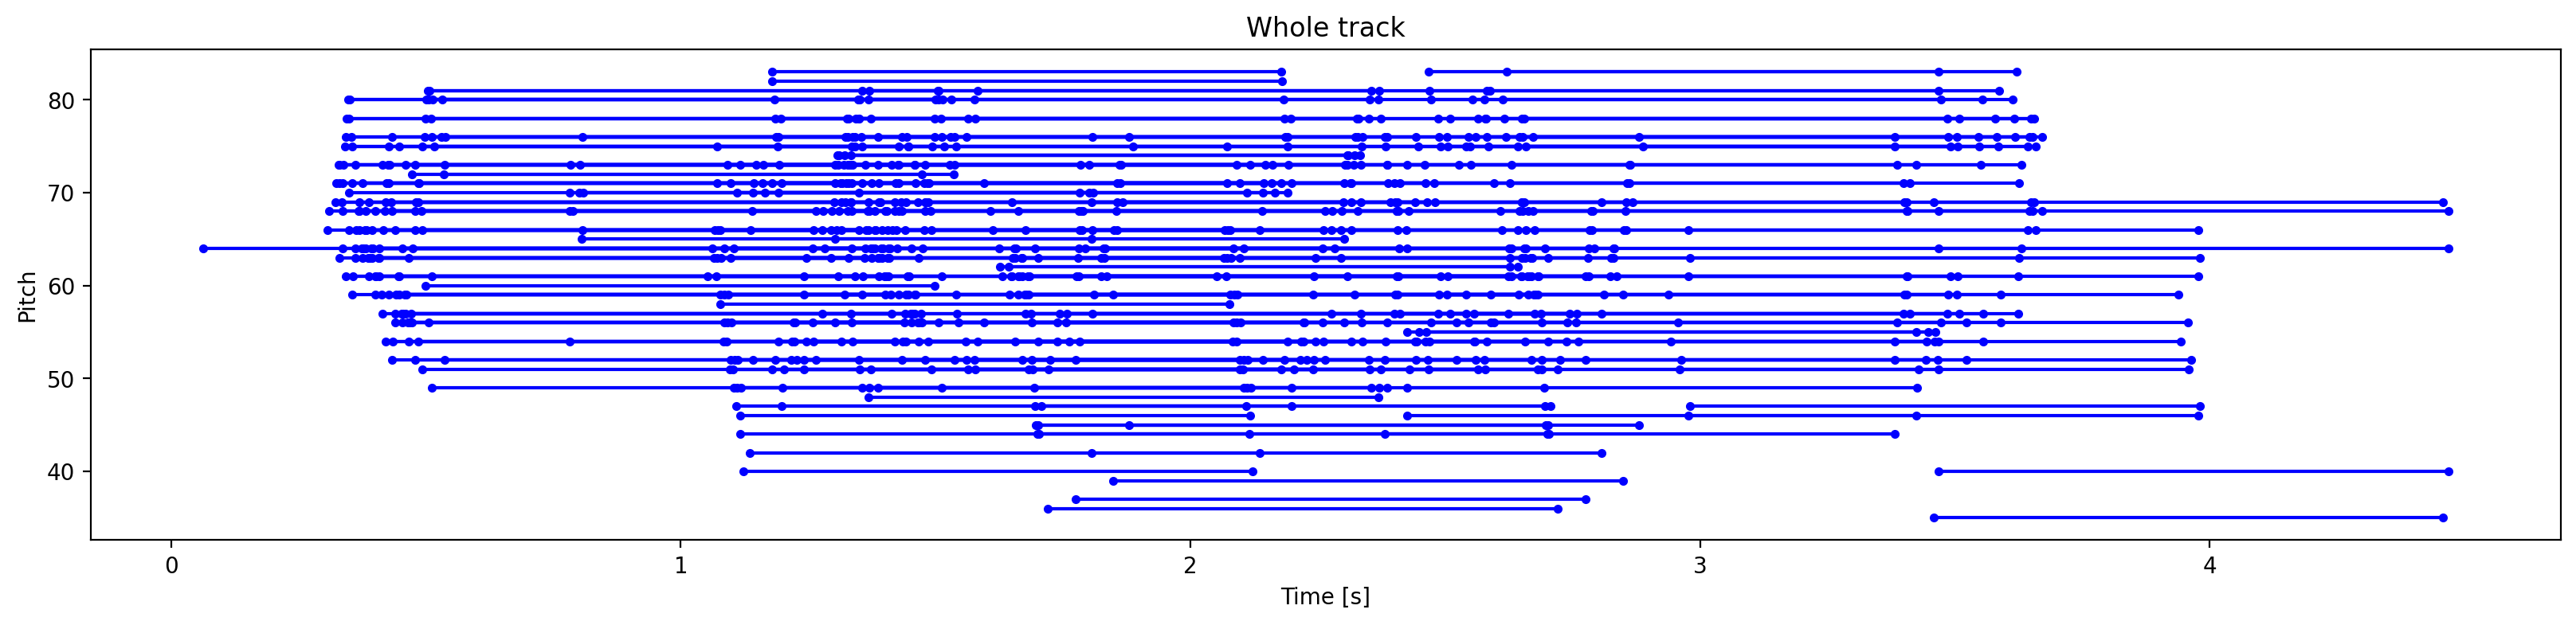

In [42]:
#@title Display Sample Audio Files (Sample Set)
from music21 import converter

count = 0
for root, _, files in os.walk(midi_directory):
    for file in files:

        if file.endswith(".mid"):
          if count >= 5:
              break
          midi_file_path = os.path.join(root, file)
          pm = pretty_midi.PrettyMIDI(midi_file_path)
          mid = MidiFile(midi_file_path)

          # Get title and composer
          composer = os.path.basename(root)
          title = file

          raw_notes = midi_to_notes(midi_file_path)
          plot_piano_roll(raw_notes)
          count += 1

In [45]:
#@title Preprocess data for CNN Model
def midi_to_image(midi_file: str, time_resolution=.5, min_pitch=21, max_pitch=108) -> np.ndarray:
    pm = pretty_midi.PrettyMIDI(midi_file)
    instrument = pm.instruments[0]
    # Determine the length of the piano roll
    max_time = max(note.end for note in instrument.notes)
    num_time_steps = int(max_time / time_resolution) + 1

    # Calculate the number of pitches within the specified range
    num_pitches = max_pitch - min_pitch + 1

    # Create an empty piano roll
    piano_roll = np.zeros((num_pitches, num_time_steps))

    for note in instrument.notes:
        pitch = note.pitch

        # Check if the pitch is within the specified range
        if min_pitch <= pitch <= max_pitch:
            start_time = int(note.start / time_resolution)
            end_time = int(note.end / time_resolution)

            # Fill the piano roll with ones where the note is active
            piano_roll[pitch - min_pitch, start_time:end_time] = 1

    return piano_roll

count = 0
max_seq_length = 0

all_features = []
all_composers = []

for root, _, files in os.walk(midi_directory):
    for file in files:
        if file.endswith(".mid"):
          #if count >= 5:
          #    break

          midi_file_path = os.path.join(root, file)
          composer = os.path.basename(root)
          features = midi_to_image(midi_file_path)

          if features is not None:
            all_features.append(features)
            all_composers.append(composer)
            max_seq_length = max(max_seq_length, features.shape[0])
          count += 1

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [46]:
# Pad sequences to the same length
padded_features = [pad_sequences(feature, maxlen=max_seq_length, padding='post') for feature in all_features]

composer_label_encoder = LabelEncoder()
composer_labels = composer_label_encoder.fit_transform(all_composers)

# Combine padded features with composer information
labeled_features_with_composer = [(feature, composer) for feature, composer in zip(padded_features, composer_labels)]

np.random.shuffle(labeled_features_with_composer)

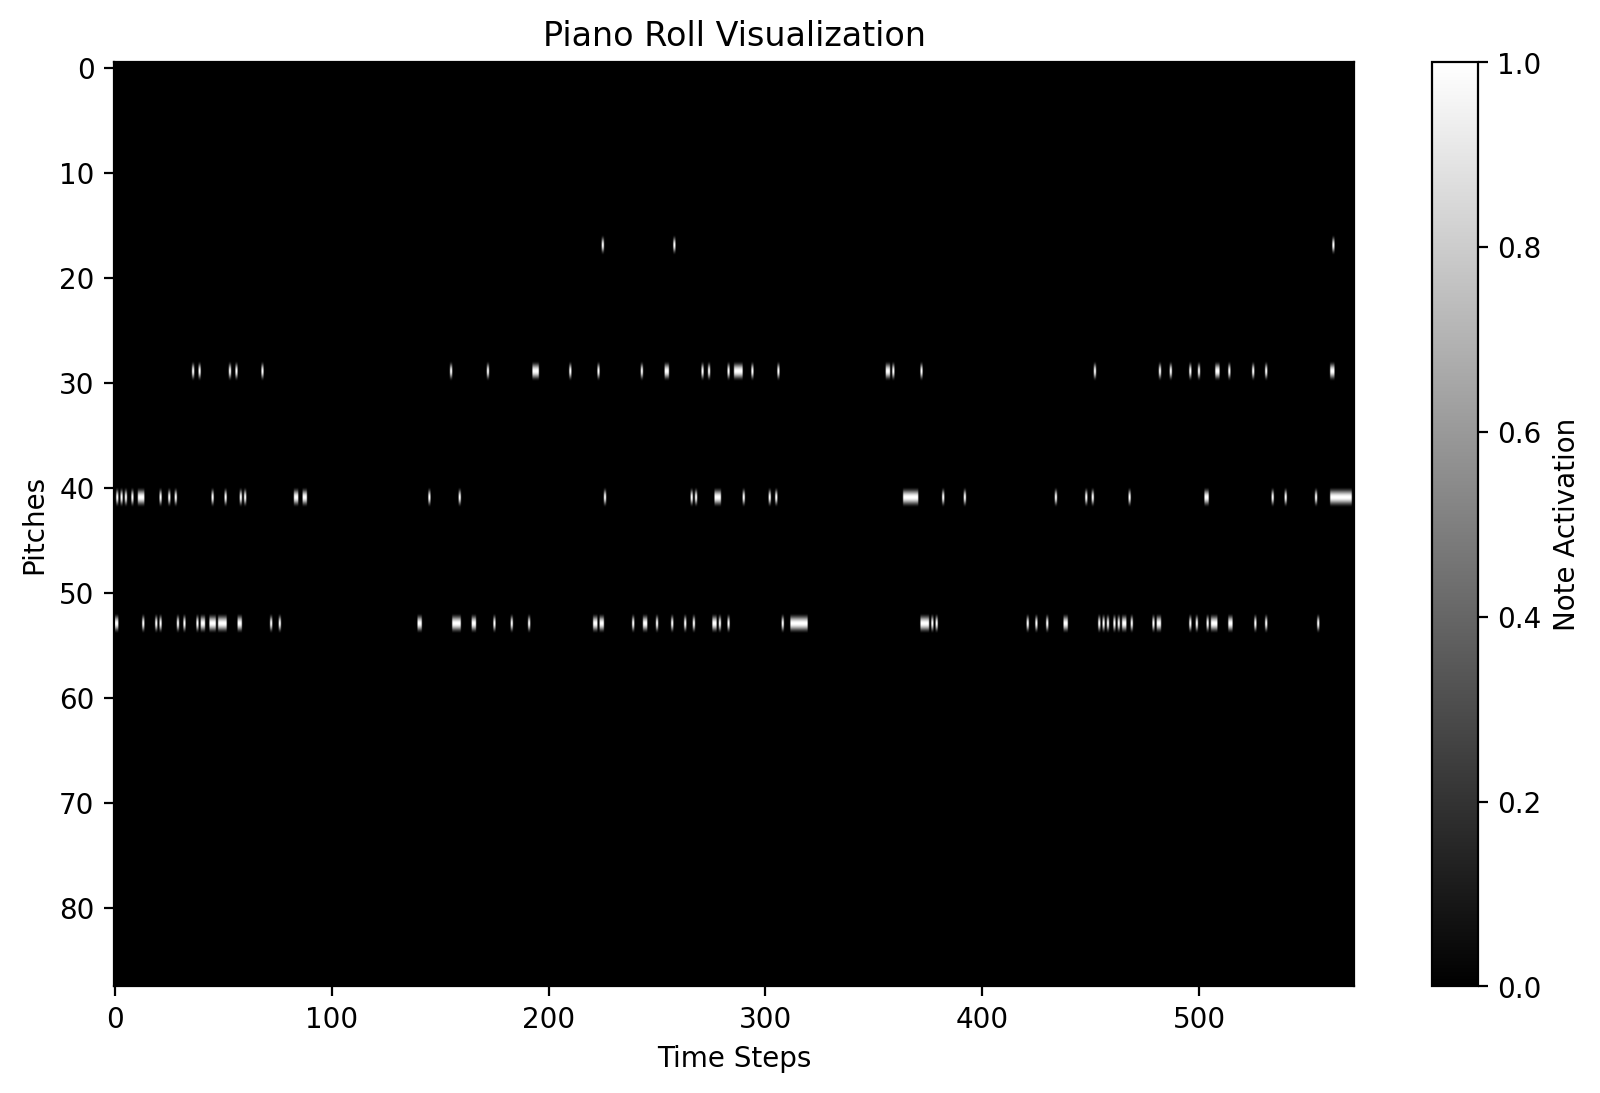

In [47]:
# Visualize the piano roll

# Select a piano roll data
selected_features = all_features[0]  # Change the index as needed

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the piano roll
plt.imshow(selected_features, aspect='auto', cmap='gray')

# Add labels and title
plt.xlabel('Time Steps')
plt.ylabel('Pitches')
plt.title('Piano Roll Visualization')

# Show the colorbar legend
cbar = plt.colorbar()
cbar.set_label('Note Activation')

# Display the visualization
plt.show()

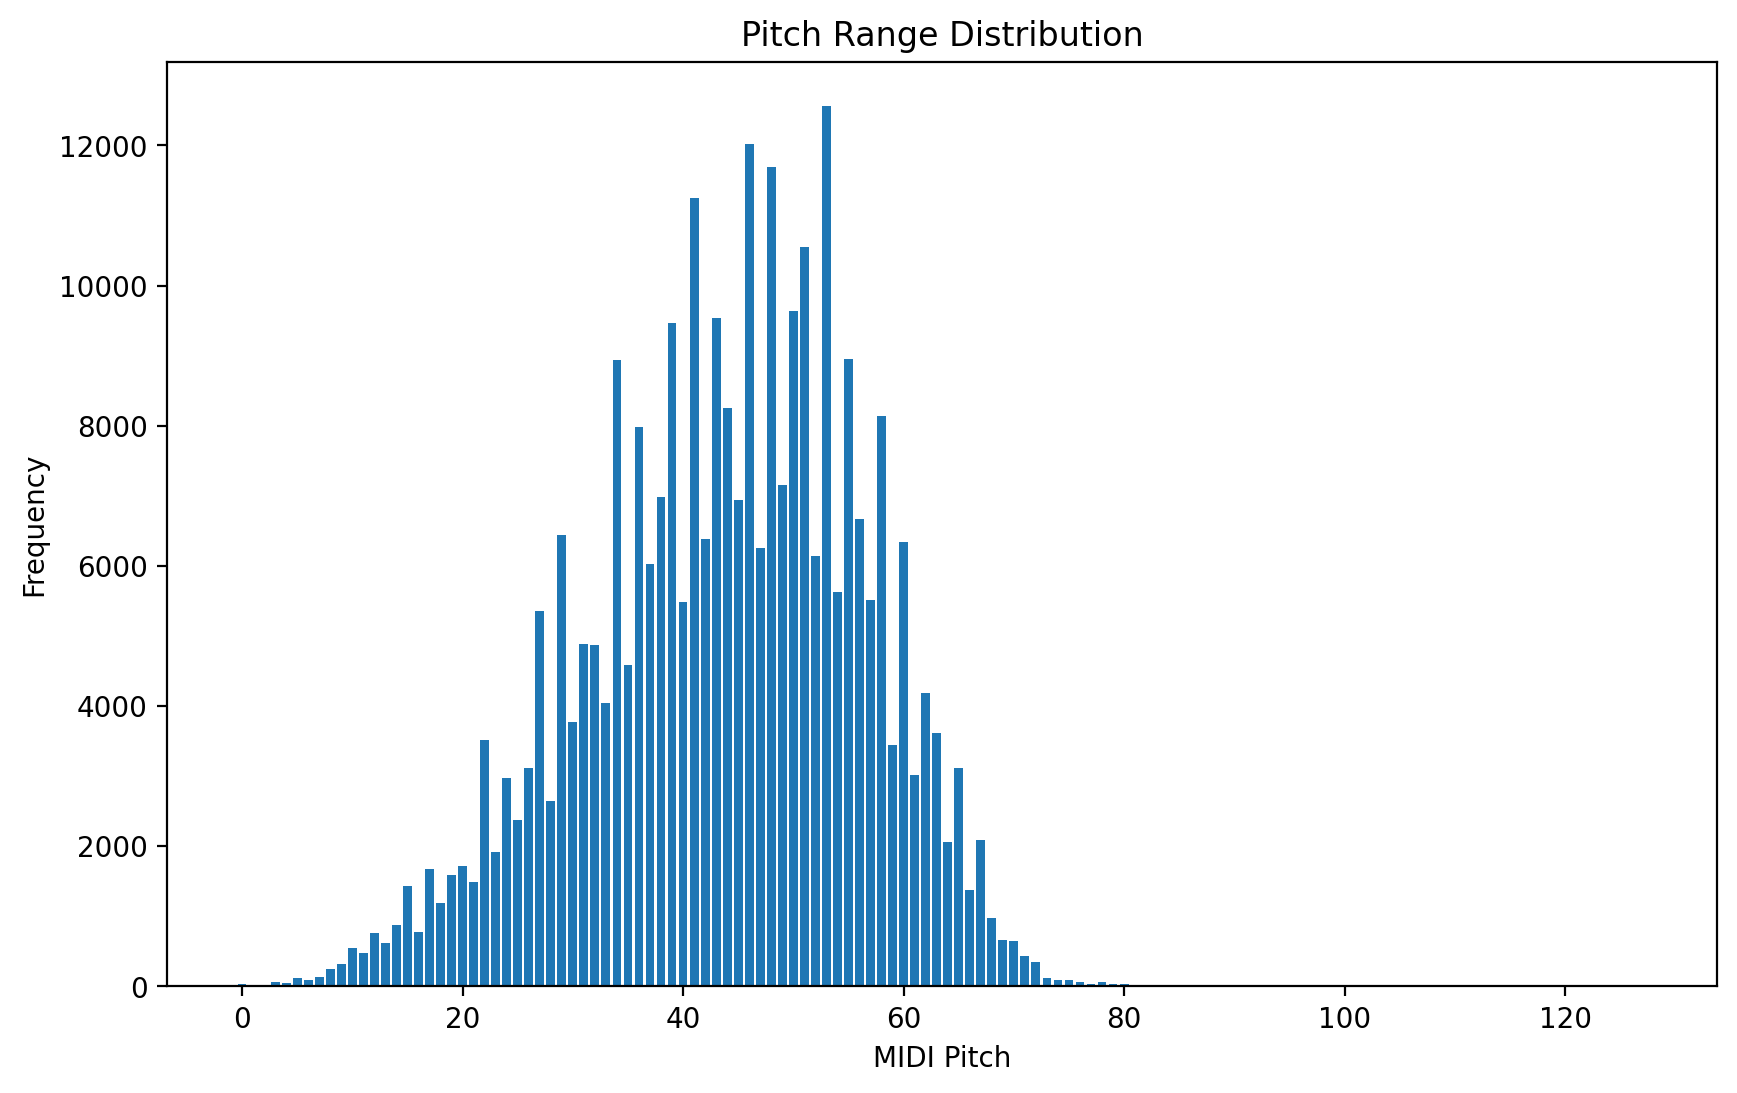

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Create a list of pitches from the MIDI dataset
pitches = []

for features in all_features:
    active_pitches = np.nonzero(features)[0]
    pitches.extend(active_pitches)

# Calculate the frequency of each pitch
pitch_counts = np.bincount(pitches, minlength=128)  # Assuming MIDI pitch range (0-127)

# Plot the pitch range distribution
plt.figure(figsize=(10, 6))
plt.bar(range(128), pitch_counts)
plt.xlabel('MIDI Pitch')
plt.ylabel('Frequency')
plt.title('Pitch Range Distribution')
plt.show()

In [49]:
#@title Identify Target Variable

# Separate features and composer information
X = [feature for feature, _ in labeled_features_with_composer]
y = [composer for _, composer in labeled_features_with_composer]

# Convert the lists to arrays
X = np.array(X)
y = np.array(y)

In [50]:
#@title Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
#@title Build the CNN model

# Reshape the input data to match CNN input shape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

model = Sequential()

# Add convolutional layers
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten the output of the last convolutional layer
model.add(Flatten())

# Add dense layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add dropout for regularization

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with softmax activation for multi-class classification
model.add(Dense(19, activation='softmax'))

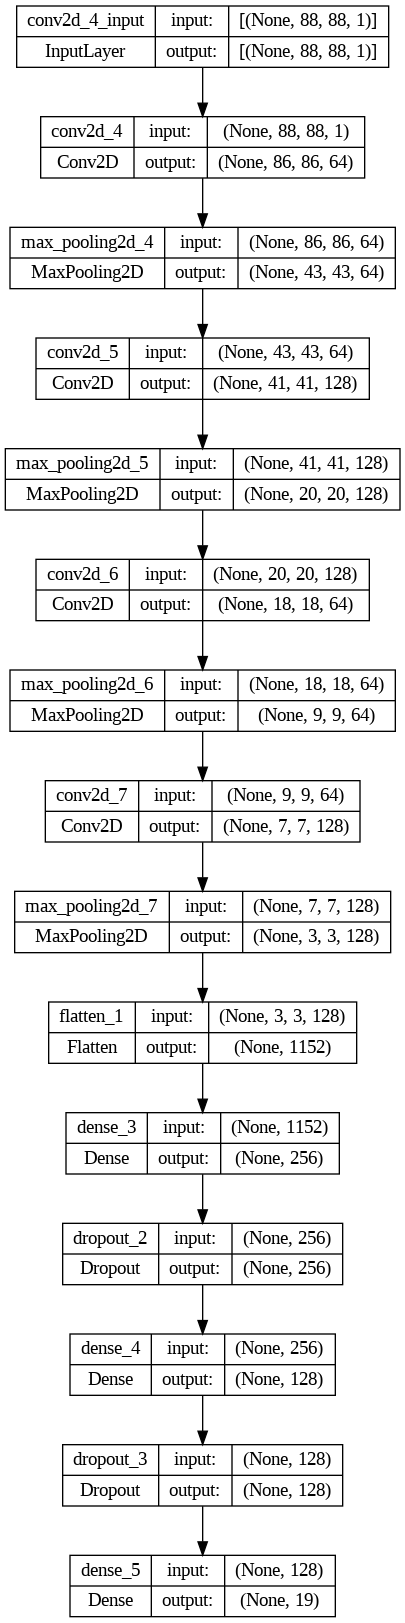

In [56]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [53]:
#@title Compile the model
from tensorflow.keras.optimizers import Adam


# Specify the desired learning rate
learning_rate = 0.01

# Create the optimizer with the desired learning rate
optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
10/10 [==============================] - 3s 40ms/step - loss: 3.2186 - accuracy: 0.0983 - val_loss: 2.4382 - val_accuracy: 0.0811
Epoch 2/10
10/10 [==============================] - 0s 22ms/step - loss: 2.3735 - accuracy: 0.1119 - val_loss: 2.2874 - val_accuracy: 0.0676
Epoch 3/10
10/10 [==============================] - 0s 21ms/step - loss: 2.2594 - accuracy: 0.1186 - val_loss: 2.2653 - val_accuracy: 0.0676
Epoch 4/10
10/10 [==============================] - 0s 18ms/step - loss: 2.2404 - accuracy: 0.1085 - val_loss: 2.2714 - val_accuracy: 0.0676
Epoch 5/10
10/10 [==============================] - 0s 17ms/step - loss: 2.2786 - accuracy: 0.0949 - val_loss: 2.2518 - val_accuracy: 0.1081
Epoch 6/10
10/10 [==============================] - 0s 17ms/step - loss: 2.2408 - accuracy: 0.1153 - val_loss: 2.2497 - val_accuracy: 0.0811
Epoch 7/10
10/10 [==============================] - 0s 18ms/step - loss: 2.2439 - accuracy: 0.0780 - val_loss: 2.2558 - val_accuracy: 0.0676
Epoch 8/10
10

In [54]:
#@title Evaluate the model on the test set

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")
print(f"Test Loss: {test_loss}")

3/3 [==============================] - 0s 9ms/step - loss: 2.2528 - accuracy: 0.1081
Test accuracy: 0.10810811072587967
Test Loss: 2.25281023979187


In [55]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate additional metrics
precision = precision_score(y_test, y_pred_classes, average='weighted', zero_division=1)
recall = recall_score(y_test, y_pred_classes, average='weighted', zero_division=1)
f1 = f1_score(y_test, y_pred_classes, average='weighted')
accuracy = accuracy_score(y_test, y_pred_classes)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")
print(f"Accuracy: {accuracy}")

3/3 [==============================] - 0s 10ms/step
Precision: 0.9035792549306063
Recall: 0.10810810810810811
F1-score: 0.021094264996704023
Accuracy: 0.10810810810810811
